# Custom shaded relief maps

![Shaded relief map of Wild Turkey Distilling Co from Blender 3D](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/wt-header.jpg)     
*Shaded relief map of Wild Turkey Distilling Co from Blender 3D*


This notebook will create a TIFF file suitable for using in Blender 3D to render custom 3D scenes.

In [5]:
############### Modules and Functions :: DO NOT EDIT ###############

# Import ArcGIS package
import arcpy
# Subprocess allows us to issue commands on the command line
import subprocess
# Get current local time
import datetime

# Allow overwriting of existing data
arcpy.env.overwriteOutput = True

############### Utility functions ###############

def setWork():
    """Create dictionary of path names from global variables 
    and return dot.notation access to dictionary attributes.
    Used internally for shorthand access to path names."""
    class dotdict(dict):
        """dot.notation"""
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__
    p = {
        "project": f'{root}\\{folder}',
        "db": f'{root}\\{folder}\\{folder}.gdb',
        "lidar": f'{root}\\{folder}\\lidar',
        "download": f'{root}\\{folder}\\download',
        "laz": f"{root}\\tools\\LAStools\\bin\\laszip64.exe",
        "lasmerge": f"{root}\\tools\\LAStools\\bin\\lasmerge64.exe",
        "grid":  f"{root}\\tools\\grids\\Phase1.gdb\\KY_5k_LAZ",
        "lasd": f'{root}\\{folder}\\download\\combined.lasd',
        "lasdaoi": f'{root}\\{folder}\\download\\aoi_e.lasd',
        "aoi": f'{root}\\{folder}\\lidar\\aoi.lasd',
        "bands": 'RED Band_1; GREEN Band_2; BLUE Band_3',
        "img": "ImageServices\\Ky_NAIP_2020_2ft",
        "dsm": f'{root}\\{folder}\\lidar\\dsm.lasd',
    }
    return dotdict(p)

def listContents(root, folder):
    """Function to print contents of a directory and report time when the cell finished processing.
    listContents(root, folder)
    Two arguments:
        root = drive letter and folder for your root GIS space (string)
        folder = path to folder in root (string)
    """
    downloads = f'{root}\\{folder}'
    completed = subprocess.run(f'dir {downloads}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))
    print("Finished processing", datetime.datetime.now())

def checkFolder(name):
    """Function to check folder name against special characters for creating project space.
    checkFolder(name)
    One argument:
        name = name of project folder for this application (string)
    """
    special = "\"\' :;\\.!@#$%^&*()-+?=,<>/"
    if any(letter in special for letter in name):
        print("Whoops! You have a special character in your project's name. \nPlease change project name.")
        return False
    else:
        print(f'Creating your project folder...')
        return True
    
############### Project Functions :: DO NOT EDIT ###############

def setUpProject():
    """Function to create project folder and database in root GIS.
    setUpProject()
    No arguments
    """
    p = setWork()
    if checkFolder(folder):
        subprocess.run(f'mkdir {p.project}', shell=True)
        print(f'Your project has been created in the {p.project} folder')
    # Create project geodatabase
    if arcpy.Exists(p.db):
        print(f'{p.db} exists!')
    else:
        print(f"Creating {p.db}")
        arcpy.CreateFileGDB_management(p.project, folder)
    arcpy.env.workspace = p.db
            
def setAoi(lat, lon, buffer):
    """Function to create area of interest and clip LAZ grid layer 
    to interactively download LAZ files.
    setAoi(lat, lon, buffer)
    Three arguments:
        lat = latitude for center of AOI (number)
        lon = longitude for center of AOI (number)
        buffer = distance, in feet, from center of AOI to include in analysis (number)
    """
    p = setWork()
    ky = arcpy.SpatialReference(3089)
    wgs84 = arcpy.SpatialReference(4326)
    arcpy.env.workspace = p.db
    point = arcpy.Point(lon, lat) 
    ptGeometry = arcpy.PointGeometry(point, wgs84)
    arcpy.env.outputCoordinateSystem = ky
    arcpy.CopyFeatures_management(ptGeometry, "point")
    arcpy.analysis.Buffer("point", "aoi", buffer)

In [6]:
############### Global variables :: EDIT for your AOI ###############

# Directory path to your root GIS folder. 
root = "c:\\YodasGIS"

# Project name - creates a folder in your root GIS directory.
folder = "wku"

# Where is your Area of Interest in Kentucky?
lat = 36.988786
lon = -86.452365

# How far in feet from the above point do you want to process the raster data?
buffer = 8000

# Set some variables for different surfaces to use
#
# Above ground, first return DSM for entire state
dsm = 'https://kyraster.ky.gov/arcgis/rest/services/ElevationServices/Ky_DSM_First_Return_5FT_Phase1/ImageServer'

# Bare-earth DEM for entire state
dem = 'https://kyraster.ky.gov/arcgis/rest/services/ElevationServices/Ky_DEM_KYAPED_5FT/ImageServer'

# Any custom raster surface model
custom = 'C:\\YodasGIS\\UkyCampus\\UkyCampus.gdb\\above_ground'

# Aerial imagery
naip = 'https://kyraster.ky.gov/arcgis/rest/services/ImageServices/Ky_NAIP_2020_2FT/ImageServer'

In [7]:
# Set up your project
setUpProject()

Creating your project folder...
Your project has been created in the c:\YodasGIS\wku folder
c:\YodasGIS\wku\wku.gdb exists!


In [8]:
# Set up the AOI
setAoi(lat, lon, buffer)

# Create a square AOI for your select point
arcpy.management.FeatureEnvelopeToPolygon('aoi', 'square_aoi')

<Result 'c:\\YodasGIS\\wku\\wku.gdb\\square_aoi'>

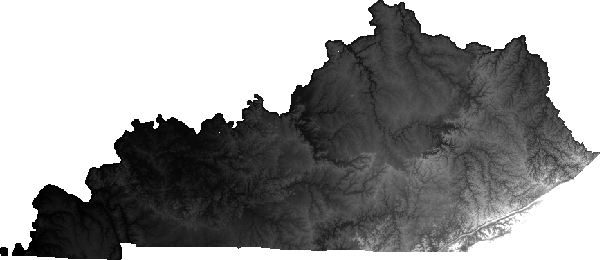

In [9]:
# Load raster
a = arcpy.sa.Raster(dsm)

# verify
a

In [ ]:
# Extract AOI and save to new layer
b = arcpy.sa.ExtractByMask(a, 'square_aoi')
b.save('original')

#Verify
b

In [11]:
# Copy original raster to a 16-bit integer raster.
arcpy.management.CopyRaster(b, 'temp', '#',  '#',  '#',  '#',  '#',  '16_BIT_UNSIGNED', True)

<Result 'c:\\YodasGIS\\wku\\wku.gdb\\temp'>

In [8]:
# Load raster and get statistics
c = arcpy.sa.Raster('temp')
c.getStatistics()

[{'min': 26649.0, 'max': 49071.0, 'mean': 32787.628431445315, 'standardDeviation': 2368.4773747495037, 'skipX': 1, 'skipY': 1, 'count': 0.0}]

In [9]:
# load low and high values
lo = c.minimum
hi = c.maximum
print(lo,hi)

26649.0 49071.0


In [10]:
# Rescale raster to full range of integer values in 16-bit format, 0-65,535
d = ((c - lo) / (hi - lo))*65535
d.save('scaled')
d.getStatistics()

[{'min': 0.0, 'max': 65535.0, 'mean': 17941.977244374382, 'standardDeviation': 6922.583448649956, 'skipX': 1, 'skipY': 1, 'count': 0.0}]

In [11]:
# Export TIFF
arcpy.management.CopyRaster('scaled', f'{root}\\{folder}\\elevations.tif', '#',  '#',  '#',  '#',  '#',  '16_BIT_UNSIGNED', True)

<Result 'c:\\YodasGIS\\wku\\elevations.tif'>

In [12]:
# Get pixel dimensions of raster for setting Blender parameters
size = arcpy.GetRasterProperties_management(d, 'COLUMNCOUNT')
print(f'Use this dimension for the X, Y size in Blender: {size.getOutput(0)}')

Use this dimension for the X, Y size in Blender: 3201


## Prepare for Blender 3D

Ok! You should have a file called *elevations.tif* in project folder. It should be a square image with an X, Y dimensions reported in the previous cell. You'll need that number for settings in Blender.

Save this notebook and your ArcGIS project. Close this application because you'll need the memory. 

If you want to color your shaded relief map in Blender, you can create a vegetation layer using the NDVI. Follow the remaining cells if you want to color your image.

## Addendum: Adding color to Blender

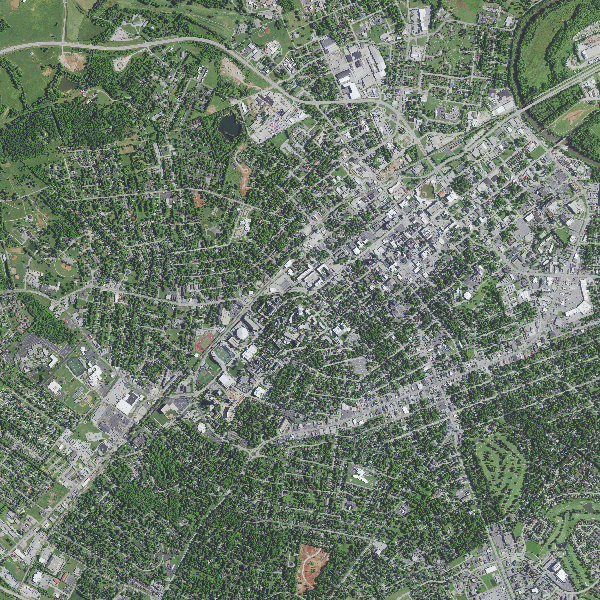

In [4]:
# Get aerial imagery
e = arcpy.sa.Raster(naip)
f = arcpy.sa.ExtractByMask(e, 'square_aoi')

#Verify
f

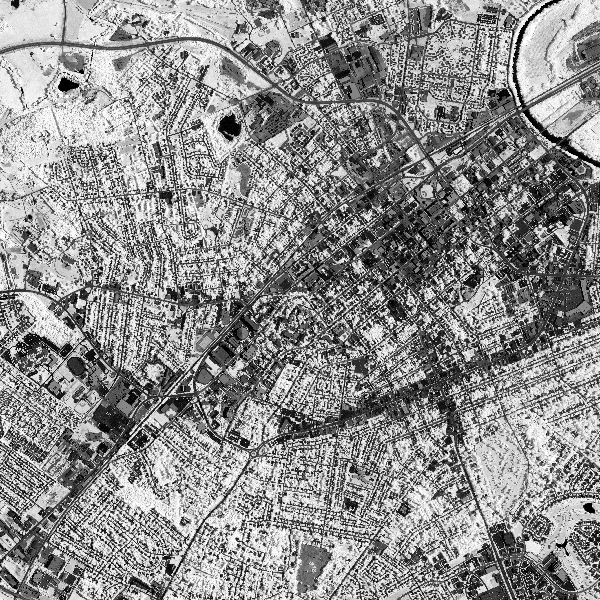

In [5]:
# Make and save NDVI
#
g = arcpy.sa.NDVI(f)
g.save('ndvi')

# Verify
g

Add the the *ndvi* layer to the Contents pane. Change the symbology to show vegetation as green and other areas as gray. Then, export the image as rendered, RGB TIFF file called, *overlay.tif*

![Style ndvi](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b01.jpg)    
*Style NDVI layer*

![Move sliders to make only vegetation green](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b02.jpg)    
*Move sliders to make only vegetation green*

<!--![Export the layer to a new file](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b03.jpg)    
*Export the layer to a new file* -->

<!--![Render the output and force RGB. This will keep the colors you've selected in the output file.](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b04.jpg)    
*Render the output and force RGB. This will keep the colors you've selected in the output file.*-->


![Before coloring](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b05.jpg)    
*Before Coloring*

![After Coloring](https://nyc3.digitaloceanspaces.com/astoria/geo409/apps/img/b06.jpg)    
*After Coloring*